In [7]:
from google.colab import drive
drive.mount('/content/drive')
path = '.../data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import pandas as pd
from fastai.vision.all import *
from sklearn.model_selection import train_test_split
import os
from glob import glob
from sklearn import metrics
import numpy as np
import random
from collections import defaultdict

In [9]:
def create_race_biased_test_set(middle_df, other_df, bias):
    """
    Creates a biased test set where the proportion of individuals identified as 'White'
    is adjusted according to the specified bias in two datasets: `middle_df` and `other_df`.

    Parameters:
        middle_df (DataFrame): The first dataset (e.g., primary dataset).
        other_df (DataFrame): The second dataset (e.g., secondary dataset).
        bias (float): The desired proportion of individuals identified as 'White' in `middle_df`.

    Returns:
        DataFrame: A concatenated DataFrame with the adjusted proportion of 'White' individuals
                    in both datasets (`middle_df` and `other_df`).
    """

    # Calculate the current proportion of individuals identified as 'White' in both datasets
    prop1 = sum(middle_df['Race/Ethnicity'].str.contains('White')) / len(middle_df)
    prop2 = sum(other_df['Race/Ethnicity'].str.contains('White')) / len(other_df)

    # Adjust the middle_df dataset based on the desired bias level
    if bias <= prop1:
        # If the target bias is smaller or equal to the current proportion of 'White' individuals,
        # oversample individuals identified as 'White' to reach the desired bias.
        biased_middle_df = pd.concat([
            middle_df,
            middle_df[middle_df['Race/Ethnicity'].str.contains('White')].sample(
                int((sum(middle_df['Race/Ethnicity'].str.contains('White')) - len(middle_df) * bias) / (1 - bias)),
                random_state=2022
            )
        ]).drop_duplicates(subset=['Path'], keep=False)
    else:
        # If the target bias is larger than the current proportion of 'White' individuals,
        # oversample individuals not identified as 'White' to reach the desired bias.
        biased_middle_df = pd.concat([
            middle_df,
            middle_df[~middle_df['Race/Ethnicity'].str.contains('White')].sample(
                int((sum(~middle_df['Race/Ethnicity'].str.contains('White')) - len(middle_df) * (1 - bias)) / bias),
                random_state=2022
            )
        ]).drop_duplicates(subset=['Path'], keep=False)

    bias2 = 1 - bias
    # Adjust the other_df dataset similarly based on the complementary bias
    if bias2 <= prop2:
        biased_other_df = pd.concat([
            other_df,
            other_df[other_df['Race/Ethnicity'].str.contains('White')].sample(
                int((sum(other_df['Race/Ethnicity'].str.contains('White')) - len(other_df) * bias2) / (1 - bias2)),
                random_state=2022
            )
        ]).drop_duplicates(subset=['Path'], keep=False)
    else:
        biased_other_df = pd.concat([
            other_df,
            other_df[~other_df['Race/Ethnicity'].str.contains('White')].sample(
                int((sum(~other_df['Race/Ethnicity'].str.contains('White')) - len(other_df) * (1 - bias2)) / bias2),
                random_state=2022
            )
        ]).drop_duplicates(subset=['Path'], keep=False)


    return pd.concat([biased_middle_df, biased_other_df])

def binarize_by_sex(df):
  #Splits a dataset into two subsets based on sex: one for males and another for females.
  male_df = df[df['Gender']=='M']
  female_df = df[df['Gender']=='F']
  return(male_df, female_df)

*CheXpert* Trained;
MIMIC Tested

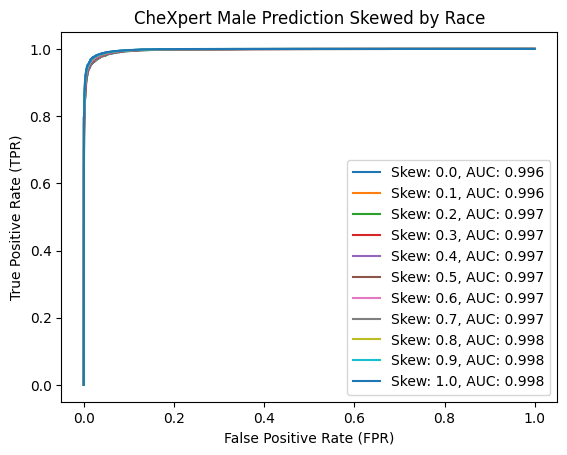

In [10]:
  df = pd.read_csv(path + '/chexpert_gender_mimic_test.csv')
  df = df[~df['Race/Ethnicity'].isna()]
  df = df[df['Race/Ethnicity']!='Unknown']

  df['Gender_Probability'] = df['Gender_Probability'].str.rstrip(']')
  df['Gender_Probability'] = df['Gender_Probability'].str.lstrip('[')
  df['Gender_Probability'] = df['Gender_Probability'].apply(np.fromstring, sep=',', dtype = float)
  male_df, female_df = binarize_by_sex(df)
  for bias in np.arange(0, 1.1, 0.1):
      biased_test_df = create_race_biased_test_set(male_df, female_df, bias)
      fpr, tpr, _ = metrics.roc_curve(y_true = biased_test_df['Gender'],y_score = [prob[1] for prob in biased_test_df['Gender_Probability']], pos_label = 'M')
      auc = metrics.auc(fpr, tpr)
      plt.plot(fpr, tpr, label=f'Skew: {bias:.1f}, AUC: {auc:.3f}')
  # Add labels, title, and legend
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.legend(loc='lower right')
  plt.title('CheXpert Male Prediction Skewed by Race')
  # Show the plot
  plt.show()

CheXpert Trained; CheXpert Tested

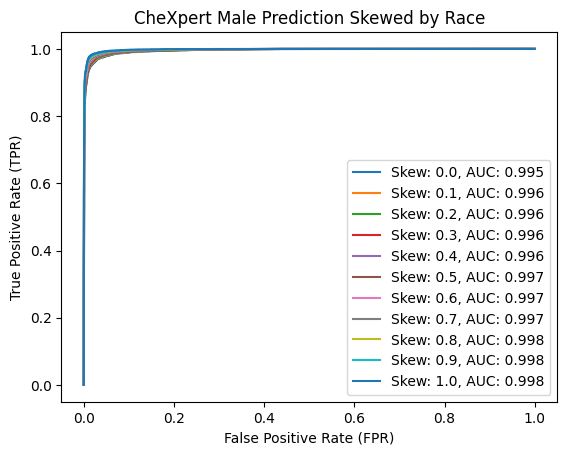

In [11]:
  df = pd.read_csv(path + '/chexpert_gender_chexpert_test.csv')
  df.loc[df['PRIMARY_RACE'] == 'Asian', 'Race/Ethnicity'] = 'Non-Hispanic Asian'
  df.loc[df['PRIMARY_RACE'] == 'Black', 'Race/Ethnicity'] = 'Non-Hispanic Black'
  df.loc[df['PRIMARY_RACE'] == 'White', 'Race/Ethnicity'] = 'Non-Hispanic White'
  df.loc[df['PRIMARY_RACE'] == 'Native American', 'Race/Ethnicity'] = 'Other'
  df.loc[df['PRIMARY_RACE'] == 'Other', 'Race/Ethnicity'] = 'Other'
  df.loc[df['PRIMARY_RACE'] == 'Unknown', 'Race/Ethnicity'] = 'Unknown'
  df.loc[df['ETHNICITY'] == 'Hispanic/Latino', 'Race/Ethnicity'] = 'Other'
  df = df[~df['Race/Ethnicity'].isna()]
  df = df[df['Race/Ethnicity']!='Unknown']
  df = df.reset_index()

  df['Gender_Probability'] = df['Gender_Probability'].str.rstrip(']')
  df['Gender_Probability'] = df['Gender_Probability'].str.lstrip('[')
  df['Gender_Probability'] = df['Gender_Probability'].apply(np.fromstring, sep=',', dtype = float)
  male_df, female_df = binarize_by_sex(df)
  for bias in np.arange(0, 1.1, 0.1):
      biased_test_df = create_race_biased_test_set(male_df, female_df, bias)
      fpr, tpr, _ = metrics.roc_curve(y_true = biased_test_df['Gender'],y_score = [prob[1] for prob in biased_test_df['Gender_Probability']], pos_label = 'M')
      auc = metrics.auc(fpr, tpr)
      plt.plot(fpr, tpr, label=f'Skew: {bias:.1f}, AUC: {auc:.3f}')
  # Add labels, title, and legend
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.legend(loc='lower right')
  plt.title('CheXpert Male Prediction Skewed by Race')
  # Show the plot
  plt.show()

MIMIC Trained; MIMIC Tested

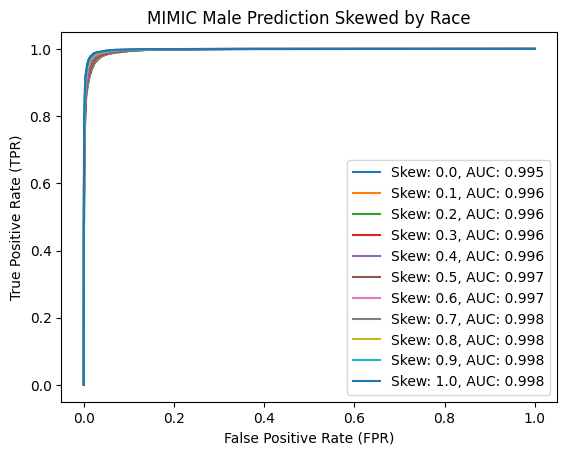

In [12]:
  df = pd.read_csv(path + '/mimic_gender_mimic_test.csv')
  df = df[~df['Race/Ethnicity'].isna()]
  df = df[df['Race/Ethnicity']!='Unknown']

  df['Gender_Probability'] = df['Gender_Probability'].str.rstrip(']')
  df['Gender_Probability'] = df['Gender_Probability'].str.lstrip('[')
  df['Gender_Probability'] = df['Gender_Probability'].apply(np.fromstring, sep=',', dtype = float)
  male_df, female_df = binarize_by_sex(df)
  for bias in np.arange(0, 1.1, 0.1):
      biased_test_df = create_race_biased_test_set(male_df, female_df, bias)
      fpr, tpr, _ = metrics.roc_curve(y_true = biased_test_df['Gender'],y_score = [prob[1] for prob in biased_test_df['Gender_Probability']], pos_label = 'M')
      auc = metrics.auc(fpr, tpr)
      plt.plot(fpr, tpr, label=f'Skew: {bias:.1f}, AUC: {auc:.3f}')
  # Add labels, title, and legend
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.legend(loc='lower right')
  plt.title('MIMIC Male Prediction Skewed by Race')
  # Show the plot
  plt.show()

MIMIC Trained; CheXpert Tested

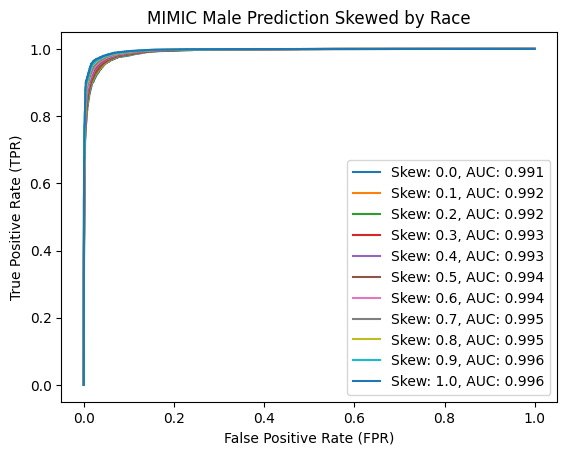

In [13]:
  df = pd.read_csv(path + '/mimic_gender_chexpert_test.csv')
  df.loc[df['PRIMARY_RACE'] == 'Asian', 'Race/Ethnicity'] = 'Non-Hispanic Asian'
  df.loc[df['PRIMARY_RACE'] == 'Black', 'Race/Ethnicity'] = 'Non-Hispanic Black'
  df.loc[df['PRIMARY_RACE'] == 'White', 'Race/Ethnicity'] = 'Non-Hispanic White'
  df.loc[df['PRIMARY_RACE'] == 'Native American', 'Race/Ethnicity'] = 'Other'
  df.loc[df['PRIMARY_RACE'] == 'Other', 'Race/Ethnicity'] = 'Other'
  df.loc[df['PRIMARY_RACE'] == 'Unknown', 'Race/Ethnicity'] = 'Unknown'
  df.loc[df['ETHNICITY'] == 'Hispanic/Latino', 'Race/Ethnicity'] = 'Other'
  df = df[~df['Race/Ethnicity'].isna()]
  df = df[df['Race/Ethnicity']!='Unknown']
  df = df.reset_index()


  df['Gender_Probability'] = df['Gender_Probability'].str.rstrip(']')
  df['Gender_Probability'] = df['Gender_Probability'].str.lstrip('[')
  df['Gender_Probability'] = df['Gender_Probability'].apply(np.fromstring, sep=',', dtype = float)
  male_df, female_df = binarize_by_sex(df)
  for bias in np.arange(0, 1.1, 0.1):
      biased_test_df = create_race_biased_test_set(male_df, female_df, bias)
      fpr, tpr, _ = metrics.roc_curve(y_true = biased_test_df['Gender'],y_score = [prob[1] for prob in biased_test_df['Gender_Probability']], pos_label = 'M')
      auc = metrics.auc(fpr, tpr)
      plt.plot(fpr, tpr, label=f'Skew: {bias:.1f}, AUC: {auc:.3f}')
  # Add labels, title, and legend
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.legend(loc='lower right')
  plt.title('MIMIC Male Prediction Skewed by Race')
  # Show the plot
  plt.show()